# <center>⚡️🏁 Quick start - тестируем простое решение</center>

In [24]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score #, mean_squared_error

from random import randint, seed

## Анализируем данные о машинах car_info

🚗 Главное описание машин с информацией о поломках для обучения / прогноза - `car_train.csv` / `car_test.csv`.

**Пояснение столбцов:**
- `car_id` - идентификатор машины
- `model` / `car_type` / `fuel_type`- марка, класс и тип топлива машины
- `car_rating` / `riders` - общий рейтинг  и общее число поездок к концу 2021-го кода.
- `year_to_start` / `year_to_work` - года выпуска машины и начала работы в автопарке 
- `main_city` - город пребывания машины. (Москва или Питер)
- `target_reg` - количество дней до поломки.
- `target_class` - класс поломки (всего 9 видов)

(2337, 10)


car_id            model car_type fuel_type  car_rating  \
439   r-1558153U          Audi Q3  premium    petrol        4.64   
546   j-3298639y      Smart Coupe  economy    petrol        5.42   
1121  I13538939n      Skoda Rapid  economy    petrol        3.66   
2037  a10698807I  Hyundai Solaris  economy    petrol        4.00   
1861  T12554358v          Kia Rio  economy    petrol        3.22   

      year_to_start  riders  year_to_work  target_reg  target_class  
439            2017  126002          2020     4620.18   electro_bug  
546            2017  118052          2019     2775.62   engine_fuel  
1121           2014   60278          2019     7003.36  engine_check  
2037           2015   77172          2020     2251.72     break_bug  
1861           2015   85200          2020     1303.03   electro_bug

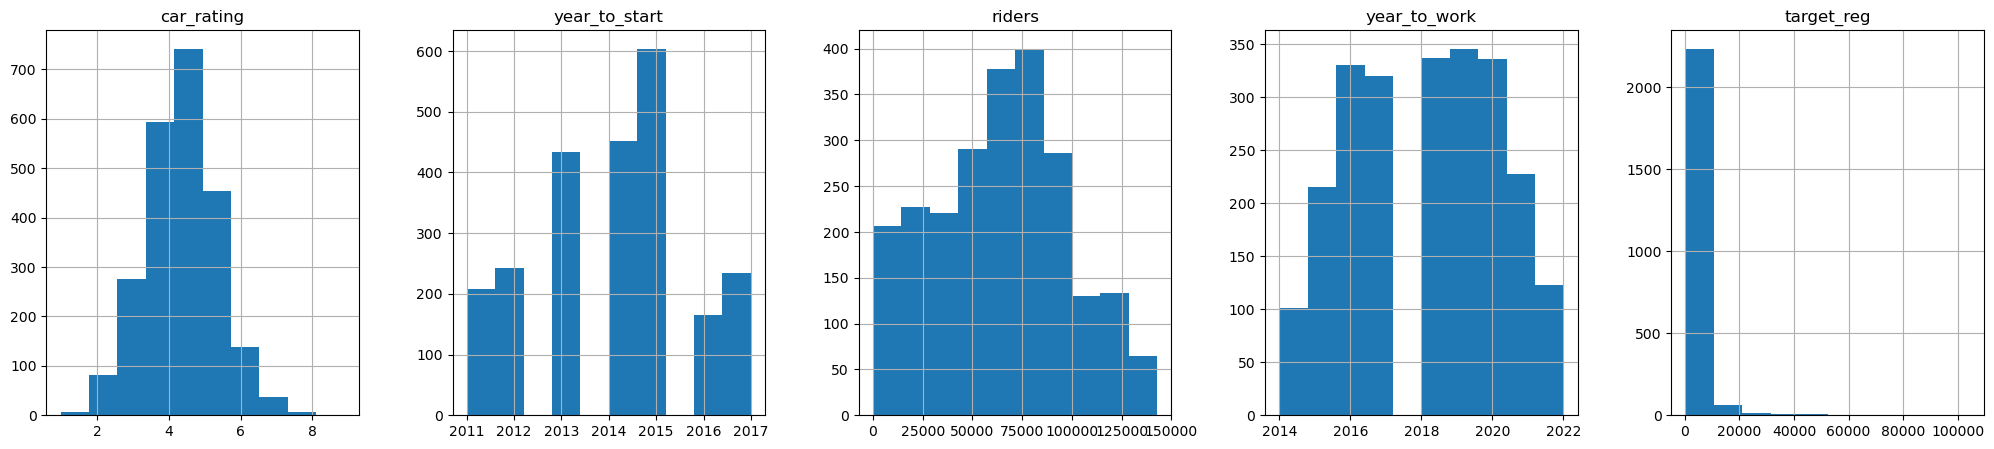

In [2]:
path = '../../data/raw/car_train.csv'
train = pd.read_csv(path)
print(train.shape)
train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [3]:
path = '../../data/raw/car_test.csv'
test = pd.read_csv(path)
print(test.shape)
test.sample(5)

(1913, 8)


car_id            model  car_type fuel_type  car_rating  \
950   W90386436H     Kia Sportage  standart    petrol        4.72   
1203  O-1094429s      Skoda Rapid   economy    petrol        4.04   
1534  W-1146682H  Renault Sandero  standart    petrol        4.44   
57    e30424190o        Kia Rio X   economy    petrol        2.54   
1026  m-4445026W  Hyundai Solaris   economy    petrol        4.42   

      year_to_start  riders  year_to_work  
950            2015   80089          2016  
1203           2016  101419          2020  
1534           2015   87198          2014  
57             2012   25458          2022  
1026           2015   84369          2018

## Классифицируем признаки на типы

In [4]:
features2drop = ['car_id'] 
targets = ['target_class', 'target_reg']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


## Добавим информацию про поездки из rides_info


🏇 Информация про поездки - `rides_info.csv`.  **Пояснение столбцов:**
- `user_id` / `car_id` / `ride_id` - идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` - дата поездки и рейтинг, поставленный водителем 
- `ride_duration` / `distance` / `ride_cost` -  длительность (время),  пройденное расстояние, стоимость поездки 
- `speed_avg` / `speed_max` - средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` - количество остановок (паузы) и флаг - была ли дозаправка.
- `user_ride_quality` - оценка манеры вождения в машины водителя, определенная скоринговой ML системой сервиса.
- `deviation_normal` - общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы). 


In [5]:
path = '../../data/raw/rides_info.csv'
rides = pd.read_csv(path)
rides.sample(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
406920  h16876384E  c96131700J     K1x  2020-02-27    5.26             40   
564391  C14726729d  n55774167X     i1F  2020-02-28    4.52              9   
91089   c18112222X  G15670643N     u1D  2020-02-16    6.82             21   
598091  J78576841z  q-8187613B     q1w  2020-01-29    0.10             36   
18514   v18994759T  B-2081255O     l1D  2020-02-07    8.29             70   

        ride_cost  speed_avg   speed_max  stop_times     distance  refueling  \
406920        329         59   95.849007           0  1022.641998          0   
564391         86         39   79.000000           0   210.688480          0   
91089         163         34   46.000000           2   646.111012          0   
598091        354         50  138.930507           0  1848.452431          0   
18514        1116         52   75.000000           2  2653.522969          0   

        user_ride_quality  deviation_normal  
406920          -6.705262             0.000  
564391          -2.391722            -8.264  
91089          -21.841510            11.477  
598091           0.046459            -7.621  
18514          -11.098212           -21.357

In [6]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

car_id  mean_rating  distance_sum  rating_min   speed_max  \
0  A-1049127W    49.459770  1.125753e+07         0.1  179.729652   
1  A-1079539w    49.591954  1.912765e+07         0.1  184.505566   

   user_ride_quality_median  deviation_normal_count  user_uniq  
0                 -0.288229                     174        172  
1                  2.508746                     174        173

In [7]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

In [8]:
train.sample(2)

car_id           model  car_type fuel_type  car_rating  \
1966  H31712627R         VW Polo   economy    petrol        3.98   
661   M-4627743Y  Renault Kaptur  standart    petrol        4.74   

      year_to_start  riders  year_to_work  target_reg  target_class  \
1966           2011     804          2017     2521.10  engine_check   
661            2014   69685          2018     2020.53     break_bug   

      mean_rating  distance_sum  rating_min   speed_max  \
1966    44.281609  1.219727e+07         0.1  175.463326   
661     45.298851  1.510999e+07         1.5  126.881565   

      user_ride_quality_median  deviation_normal_count  user_uniq  
1966                  4.009534                     174        171  
661                  -0.600331                     174        173

In [9]:
train.to_csv('quickstart_train.csv', index=False)

# Снова обновляем типы фичей

In [10]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Обучаем Catboost на новых данных и делаем новый прогноз

In [11]:
cv = 10
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

In [56]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

models = []
scores = []

seed(42)
for i, (train_ind, test_ind) in enumerate(skf.split(X, y)):
    X_train = X.loc[train_ind].copy()
    y_train = y.loc[train_ind].copy()

    X_test = X.loc[test_ind].copy()
    y_test = y.loc[test_ind].copy()

    clf = CatBoostClassifier(cat_features=cat_features, n_estimators = 150, random_state=43)
    clf.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, plot=True)

    models.append(clf)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

    print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5160559	test: 1.5241279	best: 1.5241279 (0)	total: 11.5ms	remaining: 1.72s
149:	learn: 0.2839116	test: 0.7257238	best: 0.7064877 (64)	total: 1.4s	remaining: 0us

bestTest = 0.7064877327
bestIteration = 64

Shrink model to first 65 iterations.
Accuracy: 0.6538461538461539



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5344333	test: 1.5174174	best: 1.5174174 (0)	total: 9.15ms	remaining: 1.36s
149:	learn: 0.3092819	test: 0.5492053	best: 0.5435694 (134)	total: 1.37s	remaining: 0us

bestTest = 0.5435694224
bestIteration = 134

Shrink model to first 135 iterations.
Accuracy: 0.7777777777777778



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5274990	test: 1.4892329	best: 1.4892329 (0)	total: 9.43ms	remaining: 1.41s
149:	learn: 0.3034852	test: 0.6257951	best: 0.6002995 (57)	total: 1.4s	remaining: 0us

bestTest = 0.6002994632
bestIteration = 57

Shrink model to first 58 iterations.
Accuracy: 0.7564102564102564



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5247477	test: 1.5370008	best: 1.5370008 (0)	total: 8.83ms	remaining: 1.31s
149:	learn: 0.2990525	test: 0.6157764	best: 0.6055578 (114)	total: 1.38s	remaining: 0us

bestTest = 0.6055578095
bestIteration = 114

Shrink model to first 115 iterations.
Accuracy: 0.7521367521367521



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5239959	test: 1.5349884	best: 1.5349884 (0)	total: 7.92ms	remaining: 1.18s
149:	learn: 0.2980219	test: 0.6512451	best: 0.6481452 (127)	total: 1.38s	remaining: 0us

bestTest = 0.6481452231
bestIteration = 127

Shrink model to first 128 iterations.
Accuracy: 0.7307692307692307



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5207168	test: 1.5218889	best: 1.5218889 (0)	total: 8.5ms	remaining: 1.27s
149:	learn: 0.2871359	test: 0.6145826	best: 0.5988120 (114)	total: 1.38s	remaining: 0us

bestTest = 0.5988119766
bestIteration = 114

Shrink model to first 115 iterations.
Accuracy: 0.7350427350427351



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226213
0:	learn: 1.5236848	test: 1.5066044	best: 1.5066044 (0)	total: 8.5ms	remaining: 1.27s
149:	learn: 0.2989646	test: 0.5979349	best: 0.5874811 (79)	total: 1.41s	remaining: 0us

bestTest = 0.587481104
bestIteration = 79

Shrink model to first 80 iterations.
Accuracy: 0.7435897435897436



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226215
0:	learn: 1.5499246	test: 1.5173239	best: 1.5173239 (0)	total: 8.46ms	remaining: 1.26s
149:	learn: 0.2950115	test: 0.5818339	best: 0.5745501 (107)	total: 1.39s	remaining: 0us

bestTest = 0.5745500615
bestIteration = 107

Shrink model to first 108 iterations.
Accuracy: 0.7424892703862661



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226215
0:	learn: 1.5445348	test: 1.5612869	best: 1.5612869 (0)	total: 8.7ms	remaining: 1.3s
149:	learn: 0.3017274	test: 0.6485615	best: 0.6375953 (89)	total: 1.4s	remaining: 0us

bestTest = 0.6375952895
bestIteration = 89

Shrink model to first 90 iterations.
Accuracy: 0.6952789699570815



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.226215
0:	learn: 1.5154621	test: 1.5112939	best: 1.5112939 (0)	total: 8.41ms	remaining: 1.25s
149:	learn: 0.3018625	test: 0.6449243	best: 0.6309877 (88)	total: 1.37s	remaining: 0us

bestTest = 0.6309877003
bestIteration = 88

Shrink model to first 89 iterations.
Accuracy: 0.7124463519313304



In [58]:
np.mean(scores)

0.7299787241847329

In [59]:
fi = clf.get_feature_importance(prettified=True)
fi

Feature Id  Importances
0                  speed_max    34.809230
1                mean_rating    32.705784
2                 rating_min    14.498537
3                  user_uniq     3.973789
4                   car_type     3.160709
5   user_ride_quality_median     2.852541
6                 car_rating     1.852301
7                     riders     1.583043
8               distance_sum     1.472616
9               year_to_work     1.293444
10                     model     1.181562
11             year_to_start     0.603532
12                 fuel_type     0.012913
13    deviation_normal_count     0.000000

In [60]:
clf.predict_proba(test[filtered_features])

array([[1.41015503e-03, 1.85534148e-04, 5.62483490e-03, ...,
        6.69860839e-01, 2.56699639e-04, 7.21401937e-04],
       [4.93087326e-04, 2.35793704e-04, 9.78942471e-01, ...,
        3.93121391e-03, 3.53334294e-04, 2.34068194e-04],
       [4.13349465e-03, 2.03397386e-01, 3.33806804e-04, ...,
        2.91212031e-04, 1.83421044e-01, 5.99693394e-01],
       ...,
       [1.17898088e-03, 3.83527946e-01, 6.03971171e-04, ...,
        7.26596575e-04, 5.59919103e-01, 4.83968544e-02],
       [2.51910269e-02, 1.31721419e-02, 7.41964799e-04, ...,
        1.39302011e-03, 3.80408919e-03, 1.94015920e-01],
       [2.06817682e-02, 8.25364944e-03, 2.61507227e-03, ...,
        4.30060349e-03, 5.74943681e-03, 1.18109033e-01]])

In [61]:
clf.classes_

array(['another_bug', 'break_bug', 'electro_bug', 'engine_check',
       'engine_fuel', 'engine_ignition', 'engine_overheat', 'gear_stick',
       'wheel_shake'], dtype=object)

In [62]:
result = np.zeros((test.shape[0], clf.classes_.shape[0]))

for i in models:
    result += i.predict_proba(test[filtered_features])

f = lambda x: clf.classes_[x]
test['target_class'] = list(map(f, result.argmax(axis=1)))
test

car_id            model  car_type fuel_type  car_rating  \
0     P17494612l      Skoda Rapid   economy    petrol        4.80   
1     N-1530212S  Renault Sandero  standart    petrol        4.32   
2     B-1154399t     Smart ForTwo   economy    petrol        4.46   
3     F12725233R    Smart ForFour   economy    petrol        2.80   
4     l-1139189J      Skoda Rapid   economy    petrol        6.56   
...          ...              ...       ...       ...         ...   
1908  x13640960Q   Nissan Qashqai  standart    petrol        2.44   
1909  Z-2276652N   Renault Kaptur  standart    petrol        4.44   
1910  F-2165841B  Hyundai Solaris   economy    petrol        5.16   
1911  x-1331529J  Hyundai Solaris   economy    petrol        5.76   
1912  J-2127749D       VW Polo VI   economy    petrol        5.10   

      year_to_start  riders  year_to_work  mean_rating  distance_sum  \
0              2013   42269          2019    51.482759  1.407539e+07   
1              2015   90014          2016    50.356322  1.970390e+07   
2              2015   82684          2017    43.068966  9.314946e+06   
3              2014   68833          2021    43.804598  9.336838e+06   
4              2013   42442          2021    52.574713  1.196250e+07   
...             ...     ...           ...          ...           ...   
1908           2015   81070          2016    44.005747  8.035217e+06   
1909           2014   70067          2019    49.994253  1.792881e+07   
1910           2011    6574          2022    45.977011  1.401163e+07   
1911           2015   85648          2018    44.666667  1.375324e+07   
1912           2015   74665          2016    45.385057  1.296505e+07   

      rating_min   speed_max  user_ride_quality_median  \
0           0.10  195.454152                 10.566220   
1           0.00  181.538685                 11.807941   
2           0.10  118.440645                 14.862538   
3           0.83  112.829785                 20.088904   
4           0.00  187.846088                  3.698460   
...          ...         ...                       ...   
1908        0.10  161.000000                  5.426149   
1909        0.10  195.394955                 -6.225923   
1910        0.22  113.091551                 -4.110241   
1911        0.10  154.105593                 -4.337686   
1912        0.10  161.395030                 -6.495097   

      deviation_normal_count  user_uniq     target_class  
0                        174        170  engine_overheat  
1                        174        174      electro_bug  
2                        174        172      wheel_shake  
3                        174        172        break_bug  
4                        174        172      electro_bug  
...                      ...        ...              ...  
1908                     174        171     engine_check  
1909                     174        172  engine_overheat  
1910                     174        172       gear_stick  
1911                     174        172     engine_check  
1912                     174        173     engine_check  

[1913 rows x 16 columns]

In [63]:
test[['car_id', 'target_class']].to_csv('simple_baseline_v2.csv', index=False)
print('CSV file saved!')

CSV file saved!


# Что дальше?

- Нажимаем `Save Version`
- Проверяем, что в `Advanced Settings` выбрано - всегда сохранять результаты ноутбука.
- Тип сохранения `Save & Run All (Commit)`
- Жмем окончательно кнопку `Save`